# 操作変数法と２段階OLS

In [1]:
import numpy as np
import pandas as pd
from linearmodels.iv import IV2SLS
import wooldridge
from scipy.stats import gaussian_kde, multivariate_normal, norm, uniform
import matplotlib.pyplot as plt
from scipy.stats import chi2

**＜仮定４が満たされない場合＞**

## 説明

### 基本的な考え方

仮定４：Zero Conditional Mean $\text{E}(u|x)=0$

仮定４a：$\text{Cov}(x,u)=0$

この仮定が満たされない理由に次の３つがあり（他にもある），その対処法となる推定方法について説明する。
* 欠落変数
* 同時方程式
* 測定誤差

この仮定４もしくは４aが満たされている場合，$x$はは**外生的説明変数**という。一方，この仮定が満たされない場合，OLS推定量は不偏性も一致性も満たさない。その場合の説明変数は**内生的説明変数**とよばれる。説明変数の内生性は経済問題に多く存在すると考えられる。例えば，既出の賃金関数を考えよう。賃金は教育や経験などに依存しているが，労働者の内在的な能力にも依存していると考えられる。能力を捉える変数が回帰式にない場合（欠落変数），その効果は誤差項$u$に入ることになる。もちろん，能力が労働者の中でランダムに存在し，仮定４もしくは４aを満たしているのであれば問題がない。しかし説明変数である教育が誤差項に含まれる能力と何らかの関係がある場合（例えば，能力の高い人がより高い教育水準を選択する），仮定４もしくは４aは満たされないことになり，OLS推定量は不偏性を満たさない（**欠落変数バイアス**がある）。

このような場合に役に立つのが**操作変数法**（`I`nstrumental `V`ariable Estimation）と呼ばれる手法である。この推定法では，ある条件を満たす内生的説明変数の代わりになる**操作変数**（外生的説明変数）を使うことにより，一致性を満たす推定量を得ることが可能となる。

（注意点）
* IV推定量は**一致性**を満たすが，この特性を活かすためには十分に大きな標本が必要である。
* 標本の大きさが小さい場合，IV推定量は不偏性を失う。
* OLS推定量と比べてIV推定量の標準誤差は大きくなる（効率性が低い）。

---
基本的なアイデアを整理するために次の単回帰式を考えよう。

$$y=\beta_0+\beta_1w+u$$

* $w$は説明変数
* $\text{Cov}(w,u)\neq 0$（即ち，$w$は内生的説明変数）

**＜操作変数の３つの条件＞**

更に，$w$に以下の条件を満たす**操作変数**（instruments）$z$があるとしよう。
1. $z$は回帰式に含まれない（除外条件）
1. $\text{Cov}(z,w)\neq 0$（高い関係性; $w$と高い相関関係がある）
1. $\text{Cov}(z,u)=0$（操作変数の外生性; 回帰式の誤差項と無相関）

この場合，操作変数法を用いて（大標本のもとで）一致性を満たす$\hat{\beta}_1$を得ることが可能となる。

---
＜推定方法の考え方＞

操作変数（IV）推定方は**２段階最小２乗法**の特殊なケースとして理解できる。
* 操作変数の数と内生変数の数が等しい場合の推定法を操作変数（IV）推定法
* 操作変数の数が内生変数の数を上回る場合の推定法を２段階最小二乗法（2 Stage Least Squares; 2SLS）

**第１段階OLS**
* 次式をOLS推定する。

$$w=\pi_0+\pi_1z+v$$

* これにより$w$を２つの要素（$\hat{w}$と$v$）に分解

    $$w=\hat{w}+v,\qquad\hat{w}=\hat{\pi}_0+\hat{\pi}_1z$$

    1. $\hat{w}$（予測値）：外生変数で説明できる$w$の部分（$z$と相関する部分）
    1. $v$（残差）：残り全て（$u$と相関する$w$の部分は吸収される）
    
* $\hat{\pi}_1$の優位性の確認
    * 一般的に有効な操作変数は以下を満たす
        * 操作変数の$t$値の絶対値 $>3.2$
    * この目安を満たさなければ弱操作変数の可能性
        * 推定量は不偏性・一致性を満たさない
    * 帰無仮説$\text{H}_0:\;\hat{\pi}_1=0$が棄却され，上の基準をクリアすれば次のステップへ

**第２段階OLS**
* 予測値$\hat{w}$を使い次式をOLS推定する。

    $$y=\gamma_0+\gamma_1\hat{w}+e$$
    
* IV（instrumentala variable）推定量：$\hat{\gamma}_1$

---
（注意点）

* 「手計算」で第１・２段階を別々にOLS推定すると，$\hat{\gamma}_j$を得ることができるが，推定量の標準誤差，検定統計量，決定係数$R^2$は有効ではない。
* `Python`の専用パッケージを使と，
    * 大標本のもとで推定量と$t$値は有効となる。
    * $R^2$は特に有用な情報を提供しない（マイナスになり得る）。従って，パラメータ制約を検定する$F$検定をする場合は「手計算」ではなくパッケージで提供されたコマンドを使うこと。

### `linearmodels`

**＜`linearmodels`の使い方＞**

回帰式を文字列で表し操作変数法を使うためにはサブパッケージ`IV2SLS`の`from_formula`をインポートする。回帰式の文字列に関して上述した定数項についての違い以外は`statsmodels`と同じである。ただ，下の回帰式の一般型に沿って内生的変数と操作変数を`~`で挟んで`[ ]`の中に入れる。

**＜`IV2SLS`回帰式の一般形＞**
```
被説明変数 ~ 定数項 + 外生的説明変数 + [内生的説明変数 ~ 操作変数]
```
* 定数項，外生的説明変数がない場合は，省いても良い。
* `[ ]`がない場合は通常のOLSとして計算される。その際，以前説明したメソッド`fit()`のオプションに要注意。
* 外生的説明変数，操作変数は複数でも可

## ケース１：単純な`IV`推定

### データ

既婚女性の教育の収益率に関するデータ`mroz`を利用して使い方を説明する。

In [2]:
mroz = wooldridge.data('mroz').dropna(subset=['lwage'])  # 列'lwage'にNaNがある行は削除する

wooldridge.data('mroz',description=True)

name of dataset: mroz
no of variables: 22
no of observations: 753

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| inlf     | =1 if in lab frce, 1975         |
| hours    | hours worked, 1975              |
| kidslt6  | # kids < 6 years                |
| kidsge6  | # kids 6-18                     |
| age      | woman's age in yrs              |
| educ     | years of schooling              |
| wage     | est. wage from earn, hrs        |
| repwage  | rep. wage at interview in 1976  |
| hushrs   | hours worked by husband, 1975   |
| husage   | husband's age                   |
| huseduc  | husband's years of schooling    |
| huswage  | husband's hourly wage, 1975     |
| faminc   | family income, 1975             |
| mtr      | fed. marg. tax rte facing woman |
| motheduc | mother's years of schooling     |
| fatheduc | father's years of schooling     |
| unem     | unem. rate in county of res

ケース１では以下の場合を考える。
* 被説明変数：`lwage`（既婚女性の賃金; 対数）
* 内生的説明変数：`educ`（既婚女性の教育年数）
* 操作変数：`fatheduc`（父親の教育年数）
* 外生的説明変数：なし

（考え方）

誤差項に既婚女性の能力が含まれている可能性があるため`educ`は内生変数の疑いがある。父親の教育年数`fatheduc`は既婚女性の教育年数`educ`と正の相関性があると思われる一方，能力自体とは無相関と仮定。

### 「自動計算」

IV推定法は2SLSの特殊なケースとして２ステップで推定することを説明したが，ここでは自動的に２ステップを計算する場合を紹介する。

まず回帰式を決める。

In [3]:
form_1 = 'lwage ~ 1 + [educ ~ fatheduc]'

`IV2SLS`モジュールの`from_formula`を使うことにより，`statsmodels`の`ols`のように回帰式を文字列で指定できる。次式では推定するモデルを設定する。

In [4]:
mod_1 = IV2SLS.from_formula(form_1, data=mroz)

`statsmodels`の`ols`のようにメソッド`.fit()`を使い推定する。（以前説明したオプションについての説明を参照）

In [5]:
res_1 = mod_1.fit(cov_type='unadjusted')

`res_1`の属性`.summary`，さらに`summary`の属性`tables`を使ってパラメータの部分だけを表示する。

In [6]:
print(res_1.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.4411     0.4451     0.9911     0.3216     -0.4312      1.3134
educ           0.0592     0.0351     1.6878     0.0914     -0.0095      0.1279


`educ`の推定値などは，上で説明したように`fatheduc`を操作変数として計算した結果である。$p$値は`0.1`よりも低いため，`10%`有意水準では係数`0`の帰無仮説を棄却できないが，`5%`水準では棄却される。

### 「手動計算」

第１・２段階のOLS推定を別々に試みる。

---
**第１段階のOLS**

In [7]:
stage_1 = 'educ ~ 1 + fatheduc'  # 回帰式

res_stage_1 =IV2SLS.from_formula(stage_1, data=mroz).fit(cov_type='unadjusted')  # OLS推定

educ_fit = res_stage_1.fitted_values  # educの予測値を取得

上の３行目のでは`res_stage_1`の属性`.fitted_values`を使い予測値を取得している。`statsmodels`を使いOLS推定した際に使った`.fittedvalues`と異なるメソッド名になっていることに注意しよう。

---
**第２段階のOLS**

In [8]:
stage_2 = 'lwage ~ 1 + educ_fit'

res_stage_2 =IV2SLS.from_formula(stage_2, data=mroz).fit(cov_type='unadjusted')  # OLS推定

print(res_stage_2.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.4411     0.4660     0.9465     0.3439     -0.4723      1.3545
educ_fit       0.0592     0.0367     1.6119     0.1070     -0.0128      0.1311


「自動計算」の場合と比べると，`Parameter`は同じことが確認できる。しかし`Std. Err.`は異なり，それに基づく他の推定値も異なることに注意。

### $OLS$推定

確認のために，操作変数法を使わずに直接OLS推定をおこなうとどうなるかを確認しよう。

In [9]:
form_ols = 'lwage ~ 1 + educ'

res_ols =IV2SLS.from_formula(form_ols, data=mroz).fit()  # OLS推定

print(res_ols.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.1852     0.1703    -1.0872     0.2770     -0.5191      0.1487
educ           0.1086     0.0134     8.1178     0.0000      0.0824      0.1349


操作変数法の推定量と大きく異なることが分かる。操作変数法と比べて`educ`の$OLS$推定量は約２倍になり，既婚女性の教育の収益率を過大評価している。`educ`と誤差項に相関性がると推測できる。

## ケース２：より複雑な`IV`推定（2SLS）

### 説明

ケース１を以下のように拡張する。
* 複数の外生的説明変数の導入（`exper`，`expersq`）
* 複数の操作変数の導入（`fatheduc`，`motheduc`）

このように複雑化しても基本的な考え方は同じである。

$$y=\beta_0+\beta_1x_1+\beta_2x_2+\beta_3w+u\qquad\quad\text{(*)}$$
    
* $\text{Cov}(w,u)\neq 0$（$w$は内生的説明変数）
* $\text{Cov}(x_k,u)=0,\;k=1,2$（$x_k$は外生的説明変数）

$w$の操作変数$z_j,\;j=1,2$は次の条件を満たす必要がある。
* $\text{Cov}(z_j,w)\neq 0$
* $\text{Cov}(z_j,u)=0$

＜2SLSの考え方＞

**第１段階OLS**
* 次式をOLS推定する。

    $$w=\pi_0+\pi_1z_1+\pi_2z_2+\pi_3x_1+\pi_4x_2+v\qquad\quad\text{(**)}$$
    
    * $x_1$と$x_2$が入る直感的な理由
        * 下で説明するように，式（\*）の`w`の代わりに式（\*\*）を使って計算する`w`の予測値を代わりに使うことになる。その際，式（\*\*）に$x_1$と$x_2$が入っていないと，`w`に元々あった$x_1$と$x_2$との関係性を除外することになる。式（\*\*）に$x_1$と$x_2$を入れるのは$x_1$と$x_2$との相関を考慮した`w`の予測値にするためである。
* $w$を２つの要素（$\hat{w}$と$v$）に分解

    $$w=\hat{w}+v,\qquad\hat{w}=\hat{\pi}_0+\hat{\pi}_1z_1+\hat{\pi}_2z_2+\hat{\pi}_3x_1+\hat{\pi}_4x_2$$
    
    1. $\hat{w}$（予測値）：外生変数だけで説明される$w$の部分（$x_1$，$x_2$，$z_1$，$z_2$と相関する部分）
    1. $v$（残差）：残り全て（$u$と相関する$w$の部分はこれに吸収される）
    
* $\hat{\pi}_1$と$\hat{\pi}_2$の優位性の確認
    * 操作変数の$F$値 $>10$
    * この目安を満たさなければ弱操作変数の可能性
        * 推定量は不偏性・一致性を満たさない
    * $\text{H}_0:\;\hat{\pi}_1=\hat{\pi}_2=0$が棄却され，上の基準をクリアすれば次のステップへ

**第２段階OLS**
* 予測値$\hat{w}$を使い次式をOLS推定する。

    $$y=\gamma_0+\gamma_1x_1+\gamma_2x_2+\gamma_3\hat{w}+e$$
    
* IV（instrumentala variable）推定量：$\hat{\gamma}_3$

### `educ`と操作変数の相関性チェック

内生的説明変数と操作変数のOLS推定を使い，相関性の検定をおこなう。

上述のとおり，一般的に有効な操作変数は以下を満たす。
* 操作変数が１つの場合
    * 操作変数の$t$値の絶対値 $>3.2$
* 複数の操作変数の場合
    * 操作変数の$F$値 $>10$

In [10]:
form_check = 'educ ~ 1 + fatheduc + motheduc'

res_check =IV2SLS.from_formula(form_check, data=mroz).fit(cov_type='unadjusted')

print(res_check.summary)

                            OLS Estimation Summary                            
Dep. Variable:                   educ   R-squared:                      0.2081
Estimator:                        OLS   Adj. R-squared:                 0.2043
No. Observations:                 428   F-statistic:                    112.45
Date:                Mon, Jun 15 2020   P-value (F-stat)                0.0000
Time:                        21:32:11   Distribution:                  chi2(2)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      9.4801     0.3200     29.627     0.0000      8.8530      10.107
fatheduc       0.1881     0.0335     5.6122     0.00

* `fatheduc`と`motheduc`のそれぞれの係数
    * `T-stat`（$t$値）$>3.2$
    * `P-value`（$p$値）は約$0$
* ２つの操作変数の係数が同時に$0$という帰無仮説の検定
    * `F-statistic`（$F$値）$>10$
    * `P-value(F-stat)`（$t$値）も約$0$

従って，`educ`と操作変数の相関性は高い。

### IV推定

上述した`IV2SLS`回帰式の一般形に基づいて回帰式を設定する。

In [11]:
form_2 = 'lwage ~ 1 + exper + expersq +[educ ~ fatheduc + motheduc]'

操作変数法を使い推定

In [12]:
res_2 =IV2SLS.from_formula(form_2, data=mroz).fit(cov_type='unadjusted')

print(res_2.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0481     0.3985     0.1207     0.9039     -0.7329      0.8291
exper          0.0442     0.0134     3.3038     0.0010      0.0180      0.0704
expersq       -0.0009     0.0004    -2.2485     0.0245     -0.0017     -0.0001
educ           0.0614     0.0313     1.9622     0.0497   7.043e-05      0.1227


IVが１つのケースと比べて`educ`の係数自体は大きく変わってはいないが，`5%`有意水準でも係数`0`の帰無仮説を棄却できるようになっている。

## シミュレーション：３つの特徴

### 一致性

（目的）
* `IV`推定量の一致性を確認する。

＜シミュレーションの内容＞

* 母集団の説明変数には`x1`と`x2`があり，`x2`を欠落変数とする単回帰分析。

    $$ y=\beta_0 + \beta_1 x_1 + u$$
    
* `z`を`x1`操作変数とする。
* ２つの推定方法
    * 操作変数`z`を使いIV法による推定
    * OLSによる推定（この場合，欠落変数バイアスが発生する）
* 標本の大きさは$1000$，標本数（ループの回数）を10000として$\hat{\beta}_1$の分布を比べる

標本数（ループの回数）

In [13]:
N = 10_000

母集団のパラメータ

In [14]:
b0 = 0.5
b1 = 1
b2 = 0.5

シミュレーションの関数を設定する。
* 引数
    * `n`：標本の大きさ
    * `m`：`x1`と`z`の共分散 $\text{Cov}(x1,z)=m$
    * `ols`（デフォルトは`False`）：OLS推定を一緒に行う場合は`True`
* 返り値
    * IV推定値のリスト（`ols=False`）
    * IV推定値のリストとOLS推定値のリスト（`ols=True`）
    
（コメント）

計算の速度を早めるために下の関数の中では`IV2SLS`は使わず`numpy`の関数を使いIVとOLS推定値を計算している。`IV2SLS`は係数の推定値だけではなく他の多くの統計値も自動的に計算するために一回の計算に比較的に長い時間を要するためである。

In [15]:
def sim_iv(n,m,ols=False):  # n=標本の大きさ, m=x1とｚの共分散
    """
    n: 標本の大きさ
    m: 説明変数と対応する操作変数の相関性の度合い
    ols: Boolean（デフォルト：False） 
        False: OLS推定とIV推定も一緒におこなう
            返り値：２つのリスト（OLSとIV推定量）
        True: IV推定のみ
            返り値：１つのリストのみ
    """
    rv_mean = [0, 0, 0]  # x1, x2, z1の平均
    rv_cov = [[1.0, 0.3, m],  # x1, x2, z1の共分散行列
              [0.3, 1.0, 0.0],  # 全ての変数の分散は１（対角成分）
              [m,   0.0, 1.0]]  # Cov(x1,x2)=0.3,  Cov(x2,z)=0, Cov(x1,z)=m,
    rv = multivariate_normal.rvs(rv_mean, rv_cov, size=n)  # x1, x2, z1をnセット抽出
    x1 = rv[:,0]  # 説明変数
    x2 = rv[:,1]  # 欠落変数
    z = rv[:,2]  # 操作変数

    b1_iv_list = []  # IV推定量を入れる空のリスト
    b1_ols_list = []  # OLS推定量を入れる空のリスト
    
    c = np.ones(n)
    
    for j in range(N):  # N回のループ
        
        u = norm.rvs(size=n)  # 母集団の誤差項
        y = b0 + b1*x1 + b2*x2 + u  # 母集団回帰式
        
        # IV 第１ステージ
        Xiv1 = np.stack([c,z],axis=1)
        pihat = np.linalg.inv((Xiv1.T)@Xiv1)@(Xiv1.T)@x1  # IV推定
        x1hat = Xiv1@pihat  # x1の予測値
        # IV 第２ステージ
        Xiv2 = np.stack([c,x1hat],axis=1)        
        beta_iv = np.linalg.inv((Xiv2.T)@Xiv2)@(Xiv2.T)@y  # IV推定
        b1_iv_list.append(beta_iv[1])  # IV推定量をリストに追加

        if ols==True:  # オプションols=Trueの場合はOLS推定もおこなう
            
            X = np.stack([c,x1],axis=1)
            beta_ols = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
            b1_ols_list.append(beta_ols[1])  # OLS推定量をリストに追加

        else:  # ols=Falseの場合はOLS推定をおこなわない
            pass

    if ols==True:  # ols=True の場合の返り値の設定
        return b1_iv_list, b1_ols_list
    
    else:  # ols=False の場合の返り値の設定
        return b1_iv_list

シミュレーションの開始

In [16]:
b1hat_iv, b1hat_ols = sim_iv(1000,0.9,ols=True)

図示

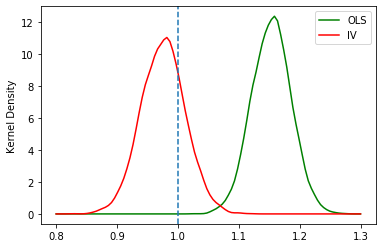

In [17]:
xx=np.linspace(0.8,1.3,num=100)  # 図を作成するために横軸の値を設定

kde_model_ols=gaussian_kde(b1hat_ols)  # OLS推定量のカーネル密度関数を計算

kde_model_iv=gaussian_kde(b1hat_iv)  # IV推定量のカーネル密度関数を計算

plt.plot(xx, kde_model_ols(xx), 'g-', label='OLS')  # OLS推定量の分布プロット
plt.plot(xx, kde_model_iv(xx),'r-', label='IV')  # IV推定量の分布プロット
plt.axvline(x=b1,linestyle='dashed')
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()  # 凡例
pass

* 欠落変数が発生しているため`OLS`推定量は一致性は満たさない。
* `IV`推定量は一致性を満たす。

### 標本の大きさ

（目的）
* `IV`推定量の一致性は大標本特性である。ここでは標本の大きさの効果を確認する。

＜シミュレーションの内容＞

* 上と同じ設定
* `IV`法による単回帰分析のみを考える
* 標本の大きさを`30`，`100`，`1000`
* それぞれ`N=10000`回推定し$\hat{\beta}_1$の分布を比べる

上で使った関数`sim_iv()`をデフォルト（`ols=False`）で使う。

In [18]:
b1hat_iv_30 = sim_iv(30,0.8)
b1hat_iv_100 = sim_iv(100,0.8)
b1hat_iv_1000 = sim_iv(1000,0.8)

図示

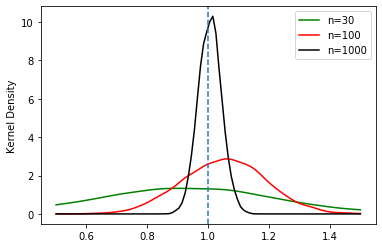

In [19]:
xx=np.linspace(0.5,1.5,num=100)  # 図を作成するために横軸の値を設定

b1hat_iv_n_list = [b1hat_iv_30, b1hat_iv_100, b1hat_iv_1000]
color_list = ['g-', 'r-', 'k-']
label_list = ['n=30', 'n=100', 'n=1000']

for (i, j, k) in zip(b1hat_iv_n_list, color_list, label_list):
    kde_model_iv=gaussian_kde(i)  # IV推定量のカーネル密度推定を設定
    b1_dist = kde_model_iv(xx)  # IV推定量のカーネル密度関数を計算
    plt.plot(xx, b1_dist, j, label=k)  # IV推定量の分布プロット

plt.axvline(x=b1,linestyle='dashed')
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()  # 凡例
pass

* 標本の大きさが増加すると，分散は低下する。
* 標本の大きさが小さい場合，不偏性は満たされないこともわかる。

### 操作変数との相関性（弱操作変数）

（目的）
* IV推定法で必須となるのが内生的説明変数と操作変数の相関性である。相関性が高い場合は推定量の標準ごさは低くなるが，逆に相関性が低い場合は推定量の標準誤差が大きくなることを確認する。

＜シミュレーションの内容＞

* 上と同じ設定
* `IV`法による単回帰分析のみを考える
* 内生的説明変数と操作変数の共分散`m`を`0.1`，`0.4`，`0.8`の3つのケースを考える。
* 標本の大きさ$2000$に固定し，それぞれ`N=10000`回推定し$\hat{\beta}_1$の分布を比べる

上で使った関数`sim_iv()`を使う。

シミュレーションの開始

In [20]:
b1hat_iv_weak = sim_iv(2000,0.1)
b1hat_iv_mid = sim_iv(2000,0.4)
b1hat_iv_strong = sim_iv(2000,0.8)

図示

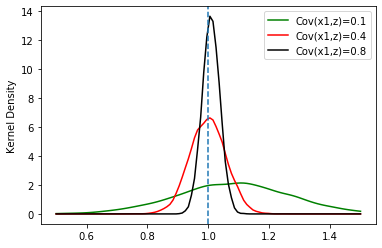

In [21]:
xx=np.linspace(0.5,1.5,num=100)  # 図を作成するために横軸の値を設定

b1hat_iv_n_list = [b1hat_iv_weak, b1hat_iv_mid, b1hat_iv_strong]
color_list = ['g-', 'r-', 'k-']
label_list = ['Cov(x1,z)=0.1', 'Cov(x1,z)=0.4', 'Cov(x1,z)=0.8']

for (i, j, k) in zip(b1hat_iv_n_list, color_list, label_list):
    kde_model_iv=gaussian_kde(i)  # OLS推定量のカーネル密度推定を設定
    b1_dist = kde_model_iv(xx)  # OLS推定量のカーネル密度関数を計算
    plt.plot(xx, b1_dist, j, label=k)  # OLS推定量の分布プロット

plt.axvline(x=b1,linestyle='dashed')
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()  # 凡例
pass

$\text{Cov}(x,z)$が低くなると分散が大きくなり，一致性を失うことも確認できる。

## 説明変数の外生性の検定

### 説明

次式を考えよう。

$$y=\beta_0+\beta_1w+u$$

* $\text{Cov}(w,u)=0$の場合，`OLS`がより良い推定量
    * `OLS`推定量は不偏性・一致性を満たす。
    * `IV-2SLS`推定量一致性を満たすが不偏性は欠き，標準誤差が大きくなり正確性を損なう。
* $\text{Cov}(w,u)\neq 0$の場合，`IV-2SLS`がより良い推定量
    * `OLS`推定量は不偏性・一致性を満たさない。
    * `IV-2SLS`推定量は一致性を満たす。

このように説明変数が外生的か内生的かによって推定量の性質が大きく異なる。では`IV`推定法と`OLS`推定法のどちらを使うべきなのか。この問題は説明変数が外生的か（$\text{Cov}(w,u)=0$）それとも内生的か（$\text{Cov}(w,u)\neq 0$）に依存しており，ここではその検定方法について説明する。

---
上で考えたケース２を使って確かめる。

### 検定方法１：`Wu-Hausman`検定

帰無仮説と対立仮説：

$\text{H}_0:\;\text{Cov}(w,u)=0$

$\text{H}_A:\;\text{Cov}(w,u)\neq 0$

---
（基本的な考え方）

帰無仮説のもとでは，`IV`推定法も`OLS`推定法も一致性も満たすため

$$\left|\hat{\beta}_j^{\text{OLS}}-\hat{\beta}_j^{\text{IV}}\right|$$

の値は小さいはず。逆に，帰無仮説が成立しない場合，`OLS`推定量は不偏性も一致性も失うことになり，上の値は大きくなる。即ち，上の値が大きければ（小さければ），帰無仮説を棄却できる可能性が高くなる（低くなる）。この考えを利用したのが`Wu-Hausman`検定である。

---
`res_2`のメソッド`.wu_hausman()`を使うと検定統計量と$p$値が表示される。

（注意）`.wu_hauseman()`であって`.wu_hauseman`ではない。

In [22]:
res_2.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 2.8035
P-value: 0.0948
Distributed: F(1,423)
WaldTestStatistic, id: 0x7f908cebe8e0

$p$値は0.0948。5%の有意水準では帰無仮説を棄却できない（外生性を棄却できない）が，10%では棄却できる。

### 検定方法２

まず検定方法について説明し，「考え方」については後述する。次の回帰式を考える。

$$y=\beta_0+\beta_1x + \beta_2w+u\qquad\qquad (\text{式１})$$

* $x$は外生的説明変数
* $w$は内生性が疑われる説明変数

---
２段階で検定する。

**第１段階**
* （式１）のOLS残差$\hat{u}$を計算する。

**第２段階**
* （式１）に$\hat{u}$を加えてOLS推定する。

    $$y=\gamma_0+\gamma_1x + \gamma_2w+\gamma_u\hat{u}+e\qquad\qquad (\text{式２})$$

* 次の検定をおこなう。
    * $\text{H}_0:\;\hat{\gamma}_u=0$（$w$は外生的である）
    * $\text{H}_A:\;\hat{\gamma}_u\neq 0$
* $\text{H}_0$が棄却されれば$w$は内生的説明変数と判断

（コメント）計算上$\hat{\gamma}_i=\hat{\beta}_i,\;i=0,1,2$が成り立つことになる。

---
**-------- 考え方 --------**

＜第１段階＞
* (式１)を推定すると$y$を$\hat{y}$と$\hat{u}$に分解することができる。

    $$y=\hat{y}+\hat{u}$$
    
    * $\hat{y}$：説明変数で説明できる$y$の部分
    * $\hat{u}$：$y$のその他の部分
* $u$が$w$と相関していれば，その相関する部分が$\hat{u}$に含まれることになる。以下のようなイメージ。

    $$\hat{u}=f\left(\hat{u}_w,v\right)$$
    
    * $\hat{u}_w$：$w$と相関する部分
    * $v$：$w$と相関しない部分

＜第２段階＞
* (式２)を推定すると，相関部分である$\hat{u}_w$を$\gamma_u\hat{u}$として取り出すことができる。
* もし$\gamma_u$が有意であれば，$\text{H}_0$は棄却される。$\hat{u}_w$は存在するということになり，$w$は内生的説明変数と判断できる。
* もし$\gamma_u$が有意でなければ，$\text{H}_0$は棄却できない。$\hat{u}_w$は存在しないということになり，$w$は外生的説明変数と判断できる。

#### 「手計算」

**第１段階**

In [23]:
form_2a = 'educ ~ 1 + exper + expersq + motheduc + fatheduc'

mod_2a = IV2SLS.from_formula(form_2a, data=mroz)

res_2a = mod_2a.fit(cov_type='unadjusted')

**第２段階**

回帰式に直接`res_2a.resids`を入れる。`resids`は`res_2a`の残差を取得する属性。

In [24]:
form_2b = 'lwage ~ 1 + educ + exper + expersq + res_2a.resids'

mod_2b = IV2SLS.from_formula(form_2b, data=mroz)

res_2b = mod_2b.fit(cov_type='unadjusted')

print(res_2b.summary.tables[1])

                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         0.0481     0.3923     0.1226     0.9024     -0.7207      0.8169
educ              0.0614     0.0308     1.9932     0.0462      0.0010      0.1218
exper             0.0442     0.0132     3.3559     0.0008      0.0184      0.0700
expersq          -0.0009     0.0004    -2.2840     0.0224     -0.0017     -0.0001
res_2a.resids     0.0582     0.0346     1.6810     0.0928     -0.0097      0.1260


$p$値は0.0928で，5%の有意水準では帰無仮説を棄却できない（内生性を棄却できない）。

#### 自動計算

`linearmodels`には上の計算を自動でおこなった結果を示すメソッドが用意されている。`res_2`の`.wooldridge_regression`である。

In [25]:
res_2.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 2.8256
P-value: 0.0928
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f908d4f1c70

（注意）「手計算」で使った`.fit()`のオプション`debiased=True`を使うと異なる数値になる。

## 操作変数の有効性検定

### 説明

次の回帰式を考えよう。

$$y=\beta_0+\beta_1x+\beta_2w+u\qquad\quad\text{(*)}$$

* $x$：外生的説明変数
* $w$：内生性が疑われる説明変数

---
**＜ケース１：１つの内生的説明変数に１つの操作変数がある場合＞**
* 操作変数$z$

この場合，操作変数の外生性$\text{Cov}(z,u)=0$が満たされないといけないが，これを検定できない。

（理由）
* 式（\*)の`w`は内生性が疑われるため，その式を使い計算したOLS残差$\hat{u}$は真の誤差項を捉えていない可能性がある。従って，この$\hat{u}$を使っても意味がある検定とはならない。
* 式（\*）に$z$を使い残差を計算することも考えられるが，そもそも$z$の有効性が分からないため，これも真の誤差項を捉えていない可能性がある。

この場合，経済理論に基づいて操作変数の外生性を正当化できるかが問題になる。

---
**＜ケース２：１つの内生的説明変数に複数の操作変数がある場合＞**
* 例えば，２つの操作変数$z_1$と$z_2$

この場合，同時に$\text{Cov}(z_1,u)=\text{Cov}(z_2,u)=0$が成立するかを検定する方法があり，その１つがSargan検定と呼ばれる。

（注意）
* Sargan検定は，全ての操作変数（上の例では２つ）が**同時**に有効かどうかを検定する。従って，どの操作変数が有効ではないかを調べることはできない。

（コメント）
* 操作変数の数が内生的説明変数の数を上回っているケースは「過剰識別（overidentified）」と呼ばれる。
* 操作変数の数と内生的説明変数の数が等しい場合は「適度識別」（just identified）と呼ばれる。

---
**Sargan検定**

２段階で検定する。

**第１段階**
* IV/2SLS推定法で推定し，残差$\hat{u}$を取得する。

**第２段階**
* 帰無仮説と対立仮説の設定
    * $\text{H}_0:\;\hat{u}$は全ての操作変数と相関性なし（全ての操作変数は外生的である）
    * $\text{H}_A:$ 少なくとも１つの操作変数は$\hat{u}$と相関する。
    * 上の例では，操作変数の数は`2`であり内生的説明変数の数は`1`であるため$q=2-1=1$の過剰識別制約があると考える。
* $\hat{u}$を被説明変数として全ての外生的説明変数と操作変数に対してOLS推定し，決定係数$R^2$を計算する。
* $LM$統計量$=nR^2$
    * $nR^2\sim\chi(q)$
    * $q>1$は操作変数の数と内生的説明変数の差
    * $n$は標本の大きさ

（帰無仮説棄却の意味）

* 少なくとも１つの操作変数は誤差項と相関性があるということになる。（欠落変数とも解釈可能）
* しかしどの操作変数が内生的かは分からない。

---
上で考えたケース２を使って確かめる。

### 「手計算」

第１段階の計算結果として`res_2`を使う。

第２段階の計算のために`res_2`の属性`.resids`を使い回帰残差を取得し，直接以下の回帰式に入れる。

In [26]:
form_aux = 'res_2.resids ~ 1 + motheduc + fatheduc + exper + expersq' # 外生的説明変数を省いてもよい

mod_aux = IV2SLS.from_formula(form_aux, data=mroz)

res_aux = mod_aux.fit(cov_type='unadjusted')

検定統計量の計算

In [27]:
r2 = res_aux.rsquared  # 決定係数
n = res_aux.nobs    # 標本の大きさ
teststat = n * r2      # 検定統計量
pval = 1 - chi2.cdf(teststat, 1)  # p値の計算
print(pval)

0.5386372330714875


５％有意水準では帰無仮説を棄却できない。

### 自動計算 

`res_2`のメソッド`.sargan`を使うと上と同じ計算結果を表示できる。

In [28]:
res_2.sargan

Sargan's test of overidentification
H0: The model is not overidentified.
Statistic: 0.3781
P-value: 0.5386
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f908cee62b0

## 同時方程式モデルと`IV`推定

### 同時性バイアス

同時方程式モデルとは，均衡メカニズムなどを通して複数の内生変数が複数の式によって同時決定されるモデルである。例として労働の需給モデルを考えよう。均衡では需要量（$L_d$）と供給量（$L_s$）は等しくなり（$L=L_d=L_s$），需要と供給はそれぞれ均衡賃金（$W$）に依存する。
* 供給関数

    $$ L = s_0+s_1 W + s_2 X_s + u_s\qquad\qquad\qquad\text{(式A)}$$

    * $s_1>0$
    * $X_s=$ 供給の「その他」の決定要因（例えば，限界費用）
    * $u_s=$ 供給の誤差項

* 需要関数

    $$ W = d_0+d_1 L + d_2 X_d + u_d\qquad\qquad\qquad\text{(式B)}$$
    
    * $d_1<0$
    * $X_d=$ 需要の「その他」の決定要因（例えば，所得）
    * $u_d=$ 需要の誤差項

（相関性の仮定）
* $\text{Cov}(X_s,u_s)=\text{Cov}(X_s,u_d)=0$
* $\text{Cov}(X_d,u_d)=\text{Cov}(X_d,u_s)=0$
* $\text{Cov}(u_s,u_d)=0$

### `IV`推定法の適用

同時性バイアスは`IV`推定法で対処可能である。考え方は簡単である。

**供給曲線（式A）の推定**
* $W$の操作変数として$X_d$を使う。$X_d$は操作変数の３つの条件を満たす。
    * （式１）にない
    * $\text{Cov}(X_d,u_s)=0$（相関性の仮定から）
    * $\text{Cov}(X_d,W)\neq 0$（式Bから）

**供給曲線（式B）の推定**
* $L$の操作変数として$X_s$を使う。$X_s$は操作変数の３つの条件を満たす。
    * （式２）にない
    * $\text{Cov}(X_s,u_d)=0$（相関性の仮定から）
    * $\text{Cov}(X_s,L)\neq 0$（式Aから）

### 例

#### データ

データセット`mroz`を使う。
* 労働供給曲線：労働市場に参加する既婚女性の労働供給関数
* 労働需要曲線：企業が提示（オファー）する賃金をその決定要因の関数として表す

上の記号に対応する変数をリストアップする（1975年のデータ）。
* $L$：`hours`（労働時間）
* $W$：`lwage`（賃金時間額の対数）
* $X_s$：労働供給の外生的説明変数
    * `age`（年齢）
    * `kidslt6`（子どもが６歳未満）
    * `nwifeinc`：（(家計の所得 - 賃金\*時間)/1000）
* $X_d$：賃金オファーの外生的説明変数
    * `exper`（雇用経験）
    * `expersq`（雇用経験の２乗）
* 両方に含まれる変数：`educ`（教育年数）

#### 供給曲線の推定

**`IV`推定**

In [29]:
form_L = 'hours ~ 1 + educ + age + kidslt6 + nwifeinc + [lwage ~ exper + expersq]'

mod_L = IV2SLS.from_formula(form_L, data=mroz)

res_L = mod_L.fit(cov_type='unadjusted')

print(res_L.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      2225.7     570.52     3.9011     0.0001      1107.5      3343.9
educ          -183.75     58.684    -3.1312     0.0017     -298.77     -68.733
age           -7.8061     9.3120    -0.8383     0.4019     -26.057      10.445
kidslt6       -198.15     181.64    -1.0909     0.2753     -554.17      157.86
nwifeinc      -10.170     6.5682    -1.5483     0.1215     -23.043      2.7039
lwage          1639.6     467.27     3.5088     0.0005      723.73      2555.4


**`OLS`推定**

In [30]:
form_L_ols = 'hours ~ 1 + educ + age + kidslt6 + nwifeinc + lwage '

mod_L_ols = IV2SLS.from_formula(form_L_ols, data=mroz)

res_L_ols = mod_L_ols.fit(cov_type='unadjusted')

print(res_L_ols.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1523.8     303.43     5.0219     0.0000      929.07      2118.5
educ          -6.6219     17.989    -0.3681     0.7128     -41.879      28.636
age            0.5623     5.1039     0.1102     0.9123     -9.4411      10.566
kidslt6       -328.86     100.74    -3.2643     0.0011     -526.31     -131.40
nwifeinc      -5.9185     3.6574    -1.6182     0.1056     -13.087      1.2500
lwage         -2.0468     54.494    -0.0376     0.9700     -108.85      104.76


２つの推定結果を比べると，推定値を含めて大きく異なることがわかる。２段回推定法により同時性バイアスを取り除いた結果と解釈できる。

#### 需要曲線の推定

**`IV`推定**

In [31]:
form_P = 'lwage ~ 1 + educ + exper + expersq + [hours ~ age + kidslt6 + nwifeinc]'

mod_P = IV2SLS.from_formula(form_P, data=mroz)

res_P = mod_P.fit(cov_type='unadjusted')

print(res_P.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.6557     0.3358    -1.9527     0.0509     -1.3139      0.0024
educ           0.1103     0.0154     7.1488     0.0000      0.0801      0.1406
exper          0.0346     0.0194     1.7847     0.0743     -0.0034      0.0726
expersq       -0.0007     0.0005    -1.5634     0.1179     -0.0016      0.0002
hours          0.0001     0.0003     0.4974     0.6189     -0.0004      0.0006


**`OLS`推定**

In [32]:
form_W_ols = 'lwage ~ 1 + educ + exper + expersq + hours'

mod_W_ols = IV2SLS.from_formula(form_W_ols, data=mroz)

res_W_ols = mod_W_ols.fit(cov_type='unadjusted')

print(res_W_ols.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.4620     0.2027    -2.2797     0.0226     -0.8592     -0.0648
educ           0.1062     0.0141     7.5400     0.0000      0.0786      0.1338
exper          0.0447     0.0133     3.3590     0.0008      0.0186      0.0708
expersq       -0.0009     0.0004    -2.1883     0.0286     -0.0016   -8.96e-05
hours      -5.655e-05  4.353e-05    -1.2992     0.1939     -0.0001   2.876e-05


労働供給の推定結果と比べて，パラメータの推定値の変化は大きくないが，統計的優位性は大きく変化している。

## 測定誤差と`IV`推定

### 測定誤差によるバイアス

ここではシミュレーションを通して，測定誤差バイアスがある場合でもIV推定法を使うことで一致性を満たす推定量を得ることが可能であることを示す。

次の母集団回帰式を考えよう。

$$y=\beta_0+\beta_1 x^* + \eta$$

ここで，被説明変数$y$は正確に測定できるが，説明変数$x^*$は以下の式に従って測定される仮定する。

$$x=x^*+e$$

* $x$：測定値
* $e$：測定誤差

（仮定）

* 測定誤差$e$は真の値と無関係。即ち，$\text{Cov}(x^*,e)=0$

（結果）

* 次式をOLS推定する場合，$\hat{\beta}_1$は不偏性・一致性を満たさない。

$$y=\beta_0+\beta_1 x + u,\qquad u=\eta-\beta e$$

（理由）

仮定４：$\text{Cov}(x,u)=0$が満たされない。

$$
\text{Cov}(x,u)=\text{E}[xu]
=\text{E}\left[(x^*+e)(\eta-\beta e)\right]
=-\beta\cdot\text{E}(e^2)>0
$$

### `IV`推定法の適用

`IV`推定法での対処方法を考える。$x^*$を測定する変数$z$があるとする。

$$z=x^*+v$$

$v\sim\text{iid}(0,\sigma)$は誤差であり，$\text{iid}$は独立同一分布を意味する。

**`IV`推定**
* $x$の操作変数として$z$を使う
* 以下の条件を満たすと仮定する。
    1. もとの式に含まれていない。
    1. $\text{Cov}(v,u)=0\;\;\Rightarrow\;\;\text{Cov}(z,u)=0$
    1. $\text{Cov}(z,x)\neq 0$（$z$も$x$も$x^*$を測定する変数）

### シミュレーション

（目的）
* 測定誤差によるバイアスを示す。
* `IV`推定法により一致性が成立することを示す。

＜シミュレーションの内容＞

* 単回帰分析

    $$ y=\beta_0 + \beta_1 x + u$$
    
* ２つのケース
    1. $OLS$推定
    2. $IV$推定
* それぞれのケースで標本の大きさ$n=100$
* 1000回推定し$\hat{\beta}_1$の分布を比べる

標本の大きさと標本数（ループの回数）

In [33]:
n = 1000
N = 10_000

母集団のパラメータの真の値

In [34]:
b0 = 1.0
b1 = 1.0

In [35]:
x_pop = uniform.rvs(1,10,size=n)  # 母集団の説明変数
u = norm.rvs(scale=1, size=n)  # 母集団の誤差項
y = b0 + b1*x_pop + u  # 母集団回帰式

測定誤差の標準偏差

In [36]:
error_sd = 3

シミュレーション開始

In [37]:
# シミュレーションで計算した推定量を入れる空のリストの作成
b1_ols_list = []  # OLS推定量
b1_iv_list = []  # IV推定量

for j in range(N):  # N回のループ
    x = x_pop + norm.rvs(scale=error_sd, size=n)  # 測定誤差
    z = x_pop + norm.rvs(scale=error_sd, size=n)  # 操作変数
    
    c = np.ones(n)  # 定数項
    
    # IV 第１ステージ
    Xiv1 = np.stack([c,z],axis=1)
    pihat = np.linalg.inv((Xiv1.T)@Xiv1)@(Xiv1.T)@x  # IV推定
    xhat = Xiv1@pihat  # x1の予測値
    # IV 第２ステージ
    Xiv2 = np.stack([c,xhat],axis=1)        
    beta_iv = np.linalg.inv((Xiv2.T)@Xiv2)@(Xiv2.T)@y  # IV推定
    b1_iv_list.append(beta_iv[1])  # b1のIV推定量をリストに追加

    # OLS
    X = np.stack([c,x],axis=1)        
    beta_ols = np.linalg.inv((X.T)@X)@(X.T)@y  # OLS推定
    b1_ols_list.append(beta_ols[1])  # b1のOLS推定量

結果の図示

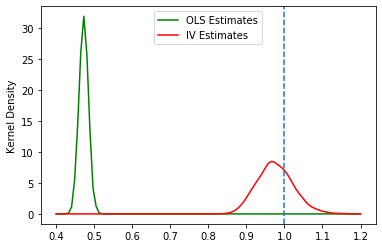

In [38]:
xx=np.linspace(0.4,1.2,num=100)  # 図を作成するために横軸の値を設定

kde_model_ols=gaussian_kde(b1_ols_list)  # t値のカーネル密度推定を設定
b1_ols_dist = kde_model_ols(xx)

kde_model_iv=gaussian_kde(b1_iv_list)  # t値のカーネル密度推定を設定
b1_iv_dist = kde_model_iv(xx)

plt.plot(xx, b1_ols_dist, 'g-', label='OLS Estimates')  # t値の分布プロット
plt.plot(xx, b1_iv_dist,'r-', label='IV Estimates')  # t分布
plt.axvline(x=b1,linestyle='dashed')
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()
pass

* OLS推定量は不偏性も一致性も満たさない。
* IV推定量は一致性を満たす。